In [2]:
## Load libraries
library(vcd)
library(vcdExtra)
library(fitdistrplus)

In [3]:
## PhD publication data:

# A data frame with 915 observations on the following 6 variables.

# articles
#   number of articles published in the final three years of PhD studies

# female
#   dummy variable for gender, coded 1 for female

# married
#   dummy variable for marital status, coded 1 for married

# kid5
#   number of young children, age 5 and under

# phdprestige
#   prestige of the PhD department. The higher the number the more prestigious the program.

# mentor
#   number of publications by the mentor in the preceeding three years

data("PhdPubs", package = "vcdExtra")
str(PhdPubs)

'data.frame':	915 obs. of  6 variables:
 $ articles   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ female     : int  0 1 1 0 1 1 1 0 0 1 ...
 $ married    : int  1 0 0 1 0 1 0 1 0 1 ...
 $ kid5       : int  0 0 0 1 0 2 0 2 0 0 ...
 $ phdprestige: int  3 2 4 1 4 4 3 3 5 1 ...
 $ mentor     : int  7 6 6 3 26 2 3 4 6 0 ...


[1] 1.692896

[1] 3.709742

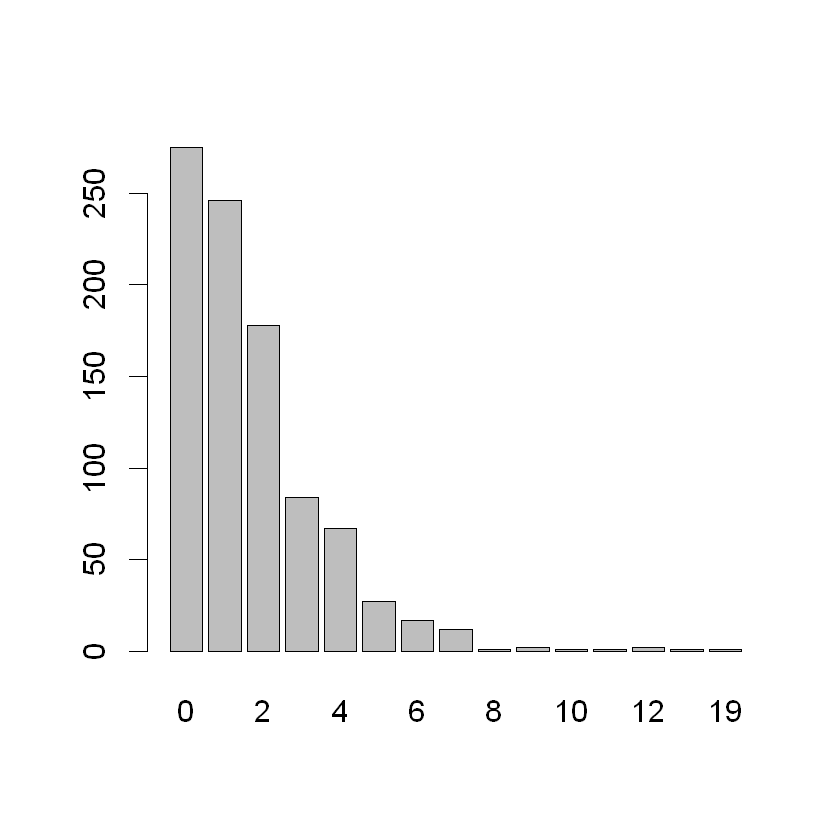

In [4]:
## No. of articles:
art.tab <- table(PhdPubs$articles)
par(cex=1.5)
barplot(art.tab)

npubs <- as.numeric( names(art.tab) )
art.counts <- rep(npubs, art.tab)

mean(art.counts)
var(art.counts)

In [5]:
## Identify factor variables:
PhdPubs$female  <- factor(PhdPubs$female, levels=c(0, 1), 
                          labels=c("male", "female"))
PhdPubs$married <- factor(PhdPubs$married, levels=c(0, 1), 
                          labels=c("unmarried", "married"))

In [6]:
## Null model:
myfit.phd.poi0 <- glm(articles~1, data=PhdPubs, family="poisson")
myfit.phd.poi0
exp( unname( myfit.phd.poi0$coefficients ) )


Call:  glm(formula = articles ~ 1, family = "poisson", data = PhdPubs)

Coefficients:
(Intercept)  
     0.5264  

Degrees of Freedom: 914 Total (i.e. Null);  914 Residual
Null Deviance:	    1817 
Residual Deviance: 1817 	AIC: 3487

[1] 1.692896

In [7]:
## Null model corresponds to fitting all data to a single Poisson:
fitdist(PhdPubs$articles, distr = "pois")

Fitting of the distribution ' pois ' by maximum likelihood 
Parameters:
       estimate Std. Error
lambda 1.692896 0.04301347

In [8]:
## Fitted to Poisson by goodfit:
plot(goodfit(PhdPubs$articles), xlab = "Number of Articles")

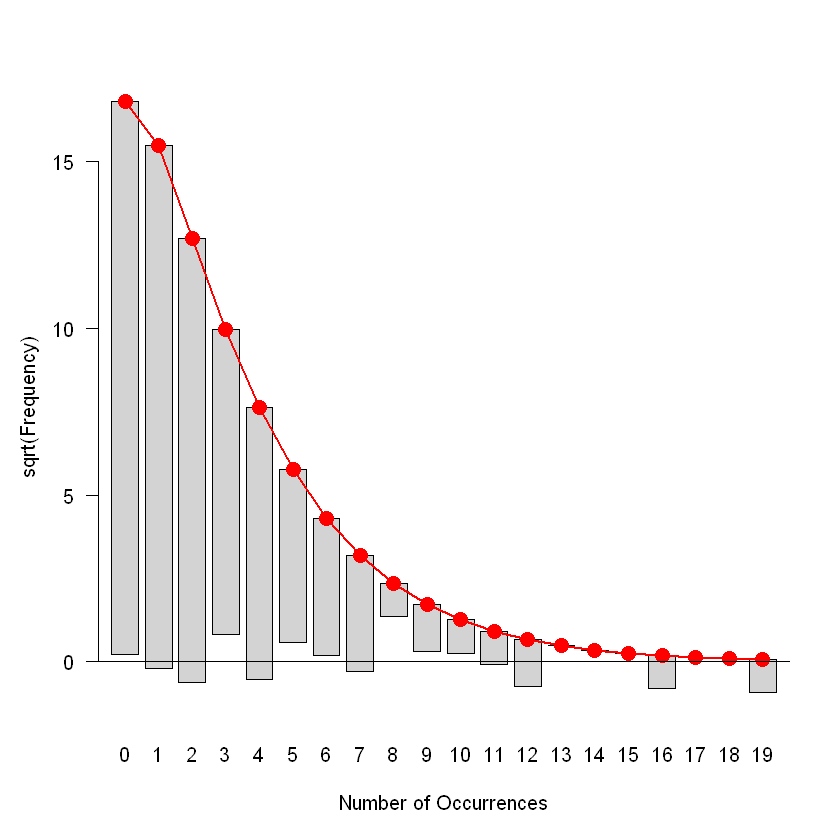

In [17]:
## Fitted to negative binomial by goodfit:
plot(goodfit(PhdPubs$articles, type = "nbinomial"))

In [19]:
## Poisson regressoin using three models, from simple to complex.

## Intercept only:
phd.pois0 <- glm(articles ~ 1, data=PhdPubs, family=poisson)

## All main effects:
phd.pois1 <- glm(articles ~ ., data=PhdPubs, family=poisson)

## All pair-wise interactions:
## (uncommon to include all interactions, just for an illustration)
phd.pois2 <- glm(articles ~ .^2, data=PhdPubs, family=poisson)

In [20]:
phd.pois1


Call:  glm(formula = articles ~ ., family = poisson, data = PhdPubs)

Coefficients:
   (Intercept)    femalefemale  marriedmarried            kid5     phdprestige  
       0.26562        -0.22442         0.15732        -0.18491         0.02538  
        mentor  
       0.02523  

Degrees of Freedom: 914 Total (i.e. Null);  909 Residual
Null Deviance:	    1817 
Residual Deviance: 1634 	AIC: 3313

In [21]:
## Compare models by LRstats:
LRstats(phd.pois0, phd.pois1, phd.pois2)

AIC      BIC      LR Chisq Df  Pr(>Chisq)  
phd.pois0 3487.147 3491.966 1817.405 914 3.304511e-62
phd.pois1 3313.339 3342.253 1633.598 909 5.378334e-44
phd.pois2 3316.147 3388.431 1618.405 900 1.121602e-43

In [23]:
## Compare (nested) models by anova:
anova(phd.pois1, phd.pois2, test="LR")

Resid. Df Resid. Dev Df Deviance Pr(>Chi)  
1 909       1633.598   NA      NA          NA
2 900       1618.405    9 15.1924  0.08578485

In [24]:
## Visual summary of effects:
library(effects)
plot(allEffects(phd.pois1))

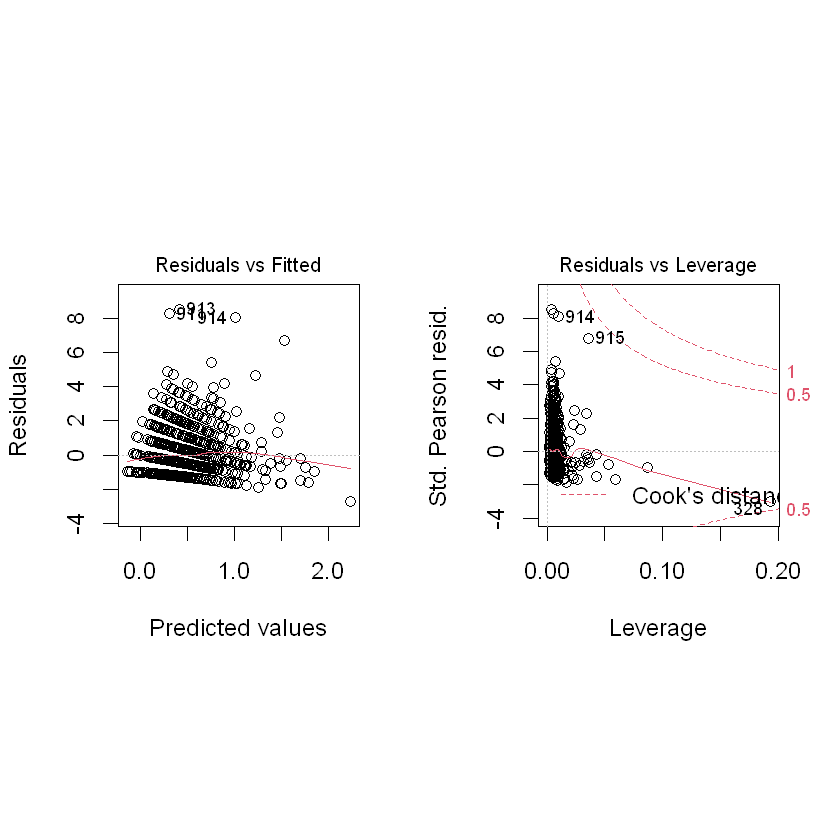

In [25]:
## Some diagnostic plots:
par(mfrow=c(1,2), cex=1.2,  pty="s")
plot(phd.pois1, which=c(1,5))

StudRes   Hat         CookD     
328 -3.734244 0.193356161 0.36757530
803 -1.034076 0.086962320 0.01490683
913  5.382111 0.003560164 0.04339156
914  5.542302 0.009995654 0.10975550
915  5.150435 0.035504369 0.28331178

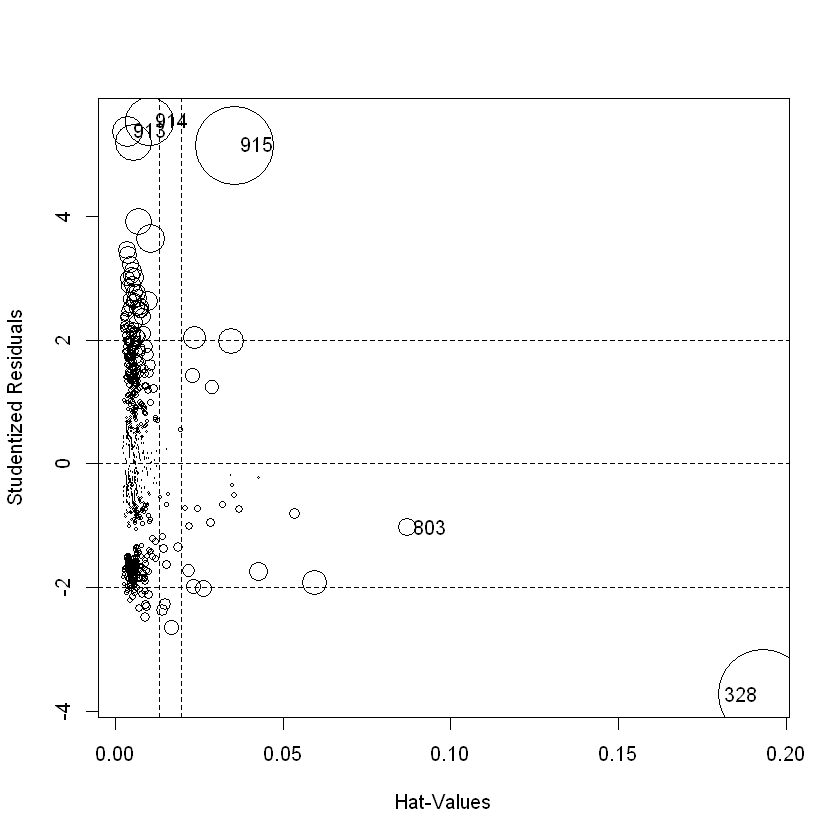

In [26]:
## Influential observations:
library(car)
influencePlot(phd.pois1)

In [27]:
## Unusual observations:
PhdPubs[c("328", "803", "913", "914", "915"), ]

articles female married kid5 phdprestige mentor
328  1       male   married 1    2           77    
803  4       male   married 2    5           66    
913 12       male   married 1    2            5    
914 16       male   married 0    2           21    
915 19       male   married 0    2           42

In [28]:
## Check for over-dispresion:

## A rough measure:
## needs to be confident that the lack-of-fit is not due to anything else.
sum(residuals(phd.pois1, type="pearson")^2) / phd.pois1$df.residual

[1] 1.830368

In [30]:
## Test for the null hypothesis of Poisson variation 
## against an alternative that the variance has a particular form
## Var(y) = mu + alpha * mu^ trafo (trafo = 1 or 2)

library(AER)
dispersiontest(phd.pois1, 1)  ## f(mu) = mu
dispersiontest(phd.pois1, 2)  ## f(mu) = mu^2


	Overdispersion test

data:  phd.pois1
z = 5.7347, p-value = 4.885e-09
alternative hypothesis: true alpha is greater than 0
sample estimates:
    alpha 
0.8259033 



	Overdispersion test

data:  phd.pois1
z = 6.4579, p-value = 5.308e-11
alternative hypothesis: true alpha is greater than 0
sample estimates:
    alpha 
0.5087683 


In [31]:
## Fit to negative binomial:
library(MASS)
phd.nbin0 <- glm.nb(articles ~ 1, data=PhdPubs)
phd.nbin1 <- glm.nb(articles ~ ., data=PhdPubs)

In [32]:
summary(phd.nbin1)


Call:
glm.nb(formula = articles ~ ., data = PhdPubs, init.theta = 2.266961466, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1359  -1.3654  -0.2807   0.4431   3.4765  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.212949   0.132741   1.604 0.108661    
femalefemale   -0.216253   0.072594  -2.979 0.002893 ** 
marriedmarried  0.152791   0.081944   1.865 0.062242 .  
kid5           -0.176339   0.052794  -3.340 0.000837 ***
phdprestige     0.029342   0.034273   0.856 0.391921    
mentor          0.028677   0.003236   8.861  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(2.267) family taken to be 1)

    Null deviance: 1109.4  on 914  degrees of freedom
Residual deviance: 1004.1  on 909  degrees of freedom
AIC: 3135.4

Number of Fisher Scoring iterations: 1


              Theta:  2.267 
          Std. Err.:  0.272 

 2 x log-lik

In [33]:
## Compare Poisson and negative binomial:
LRstats(phd.pois1, phd.nbin1)

AIC      BIC      LR Chisq Df  Pr(>Chisq)  
phd.pois1 3313.339 3342.253 1633.598 909 5.378334e-44
phd.nbin1 3135.367 3169.100 1004.105 909 1.490250e-02

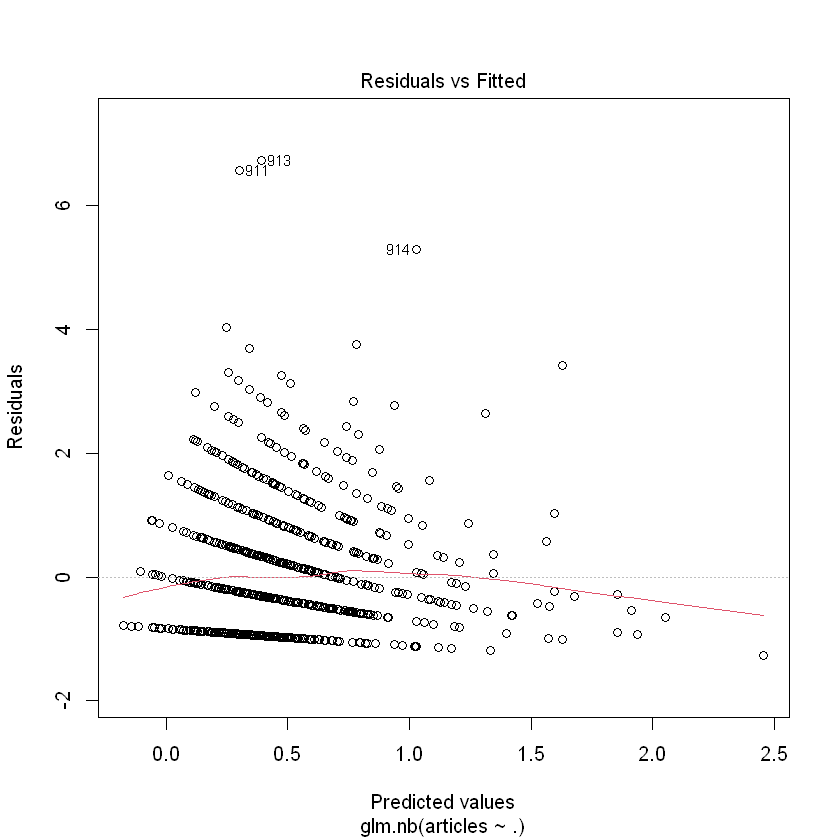

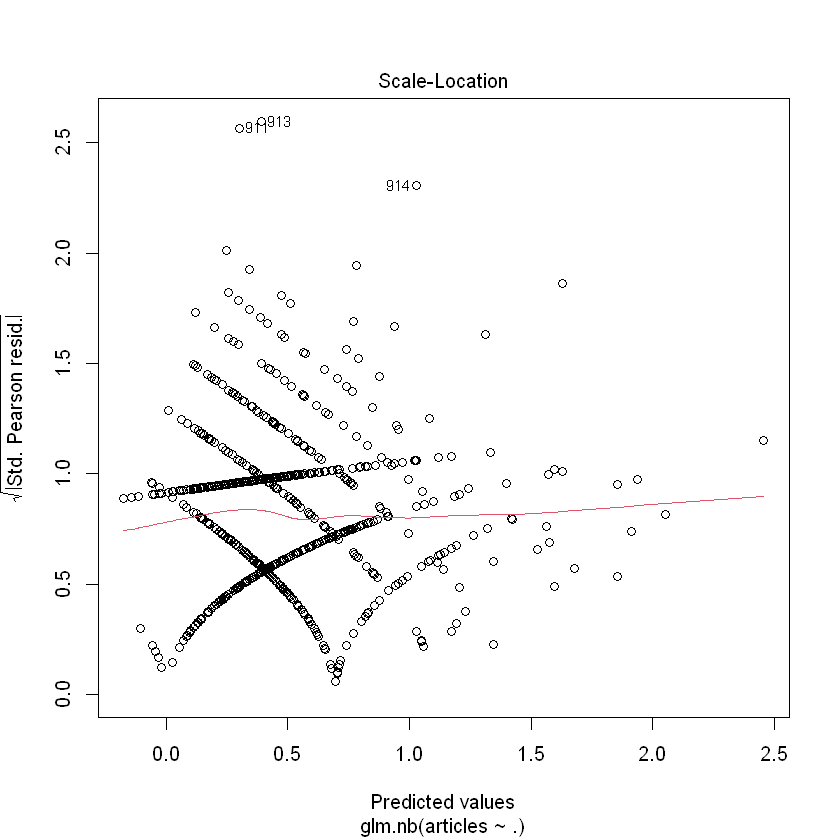

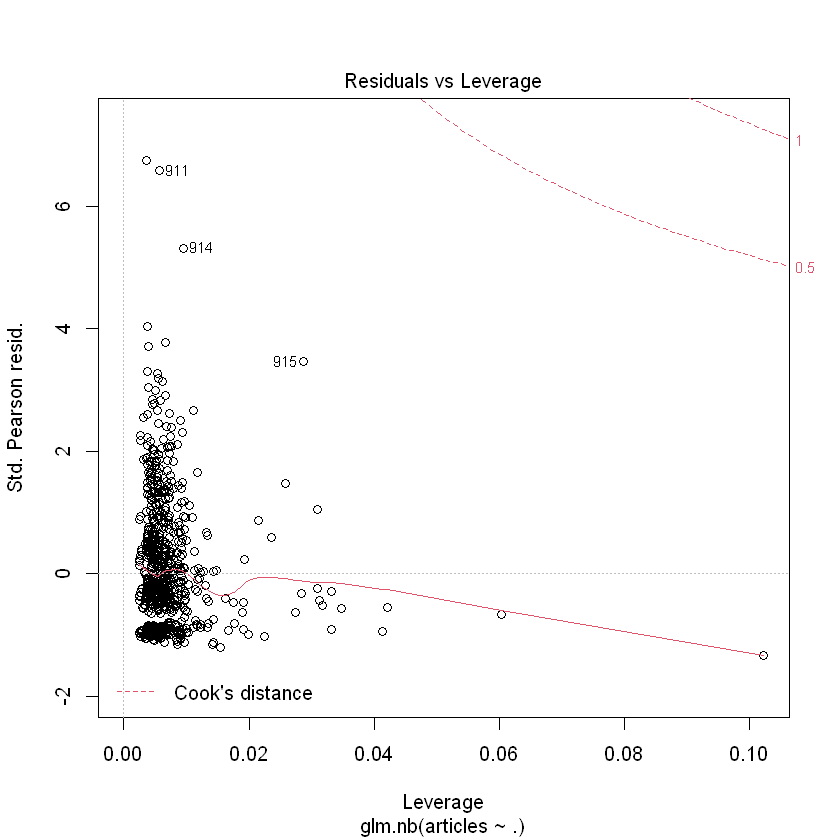

In [34]:
## Some diagnostic plots:
plot(phd.nbin1, which=c(1,3,5))

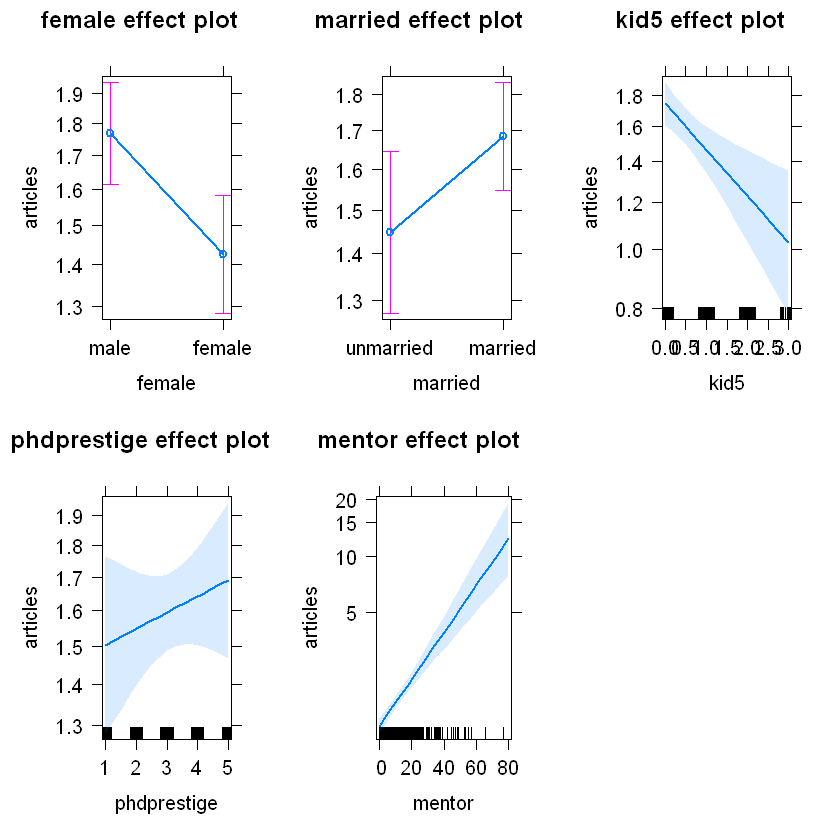

In [35]:
## Effect plots:
plot(allEffects(phd.nbin1))

In [37]:
## rootogram to visualize goodness-of-fit of models:
# install.packages("countreg", repos="http://R-Forge.R-project.org")
library(countreg)
countreg::rootogram(phd.pois1, max = 12, main = "PhDPubs: Poisson")
countreg::rootogram(phd.nbin1, max = 12, main = "PhDPubs: Negative-Binomial")

In [39]:
## zero-inflated model.

## More parameters are needed in order to predict the zero components.
## Sometimes useful to separately model the zero counts.

library(pscl)
phd.zip1 <- zeroinfl(articles ~ ., data=PhdPubs, dist="poisson")
summary(phd.zip1)


Call:
zeroinfl(formula = articles ~ ., data = PhdPubs, dist = "poisson")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-2.2751 -0.8656 -0.2839  0.5403  7.4055 

Count model coefficients (poisson with log link):
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.599179   0.118615   5.051 4.38e-07 ***
femalefemale   -0.208791   0.063526  -3.287  0.00101 ** 
marriedmarried  0.106229   0.070966   1.497  0.13442    
kid5           -0.142706   0.047436  -3.008  0.00263 ** 
phdprestige     0.006998   0.029812   0.235  0.81441    
mentor          0.017846   0.002334   7.647 2.05e-14 ***

Zero-inflation model coefficients (binomial with logit link):
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)    -0.56331    0.49405  -1.140  0.25421   
femalefemale    0.10816    0.28173   0.384  0.70106   
marriedmarried -0.35559    0.31796  -1.118  0.26343   
kid5            0.21974    0.19658   1.118  0.26365   
phdprestige    -0.00537    0.14118  

In [40]:
## The "LR Chisq" of phd.pois1 and phd.nbin1 have different values when phd.zip1 is included. (why?)
## (Guess: the package is assuming a Poisson-logit model for all three models when calculting likelihood.)
LRstats(phd.pois1, phd.nbin1, phd.zip1)

AIC      BIC      LR Chisq Df  Pr(>Chisq)   
phd.pois1 3313.339 3342.253 3301.339 909 8.686124e-268
phd.nbin1 3135.367 3169.100 3121.367 909 9.732705e-240
phd.zip1  3233.518 3291.345 3209.518 903 4.744953e-255